In [ ]:
!pip install transformer_lens datasets torch accelerate
!pip install matplotlib
!pip install seaborn
!pip install openai


In [ ]:
from huggingface_hub import login
huggingface_token = "hf_..."
login(token=huggingface_token)
device = 'cuda'

In [ ]:
import torch
#from transformer_lens import HookedTransformer
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import random

##### Originally I thought we could use the transformer lens library to get the activations of the reasoning model, but it wasn't compatible, So I used simple hooks to get the activations from the latent layer streams of the model during the inference process.

In [ ]:
#base_model = HookedTransformer.from_pretrained('meta-llama/Llama-3.1-8B', device='cuda', dtype=torch.float16)

In [ ]:
# Using the model directly from huggingface, using hooks directly to hook into the model
def gather_all_layer_activations(model, inputs):
    layer_activations = {}

    def create_hook(layer_idx):
        def hook(mod, inputs, outputs):
            layer_activations[f"layer_{layer_idx}"] = inputs[0].detach()
            return outputs
        return hook

    handles = []
    for idx in range(len(model.model.layers)):
        handle = model.model.layers[idx].register_forward_hook(
            create_hook(idx)
        )
        handles.append(handle)

    # Run model and get output
    with torch.no_grad():
        output = model.generate(
            inputs,
            max_new_tokens=50000,  # Adjust as needed
            do_sample=True,
            temperature=0.7
        )

    # Clean up hooks
    for handle in handles:
        handle.remove()

    return layer_activations, output

In [ ]:
#This is where we looked at the differrent layer activations and tried to see if we could find a pattern in the activations
def analyze_reasoning_bands(model, tokenizer, prompt, max_new_tokens=500):
    """Analyze activation patterns in the three processing bands during generation."""
    # Store activations for each band
    early_acts = []    # Layers 0-10
    middle_acts = []   # Layers 11-21
    late_acts = []     # Layers 22-31
    tokens = []

    def create_hook(layer_idx, storage):
        def hook(mod, inputs, outputs):
            # Store the residual stream input
            storage.append({
                "layer": layer_idx,
                "activation": inputs[0].detach().clone()
            })
            return outputs
        return hook

    # Register hooks for all layers we're interested in
    handles = []
    for idx in range(32):  # Total 32 layers
        storage = early_acts if idx <= 10 else (
            middle_acts if idx <= 21 else late_acts
        )
        handle = model.model.layers[idx].register_forward_hook(
            create_hook(idx, storage)
        )
        handles.append(handle)

    # Generate token by token
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    generated_tokens = []

    with torch.no_grad():
        for _ in range(max_new_tokens):
            outputs = model(input_ids)
            next_token = outputs.logits[:, -1, :].argmax(dim=-1)

            # Store token
            token_text = tokenizer.decode(next_token)
            tokens.append(token_text)
            generated_tokens.append(next_token.item())

            # Break if end of sequence
            if next_token.item() == tokenizer.eos_token_id:
                break

            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)

    # Clean up hooks
    for handle in handles:
        handle.remove()

    result = {
        "tokens": tokens,
        "early_band": early_acts,
        "middle_band": middle_acts,
        "late_band": late_acts,
        "generated_ids": generated_tokens
    }

    return result

def visualize_reasoning_bands(analysis_results, focus_late=True):
    """Visualize activation patterns across processing bands."""
    plt.figure(figsize=(20, 12))

    # 1. Late Layer Focus (layers 22-31)
    if focus_late:
        plt.subplot(2, 2, 1)
        late_layers = range(22, 32)
        for layer in late_layers:
            activations = [
                acts["activation"].mean().item()
                for acts in analysis_results["late_band"]
                if acts["layer"] == layer
            ]
            plt.plot(activations, label=f"Layer {layer}", alpha=0.7)
        plt.title("Late Layers Activation Patterns")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 2. Band Comparison
    plt.subplot(2, 2, 2)
    band_names = ["Early (0-10)", "Middle (11-21)", "Late (22-31)"]
    band_data = [
        analysis_results["early_band"],
        analysis_results["middle_band"],
        analysis_results["late_band"]
    ]

    for name, data in zip(band_names, band_data):
        mean_acts = [
            acts["activation"].mean().item()
            for acts in data
        ]
        plt.plot(mean_acts, label=name, alpha=0.7)
    plt.title("Processing Band Comparison")
    plt.legend()

    # 3. Activation Heatmap
    plt.subplot(2, 1, 2)
    all_activations = []
    for t in range(len(analysis_results["tokens"])):
        layer_acts = []
        for l in range(32):
            # Find activation for this layer and token
            acts = None
            for band in [analysis_results["early_band"],
                        analysis_results["middle_band"],
                        analysis_results["late_band"]]:
                for act in band:
                    if act["layer"] == l:
                        acts = act["activation"].mean().item()
                        break
                if acts is not None:
                    break
            layer_acts.append(acts if acts is not None else 0)
        all_activations.append(layer_acts)

    sns.heatmap(
        np.array(all_activations).T,
        cmap='viridis',
        xticklabels=analysis_results["tokens"],
        yticklabels=range(32)
    )
    plt.title("Layer Activation Patterns During Generation")
    plt.xlabel("Generation Steps")
    plt.ylabel("Layer")

    plt.tight_layout()
    plt.show()

    # Clean up memory after plotting
    plt.close()
    torch.cuda.empty_cache()

In [ ]:
# A more detailed visualization, looking at some stats also
def analyze_cot_reasoning(model, tokenizer, prompt):
    # Same as before, but return more detailed stats
    inputs = tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}],
        return_tensors="pt"
    ).to(model.device)

    activations, output = gather_all_layer_activations(model, inputs)
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    layer_stats = {}
    activation_matrices = {}  # Store full activation matrices for visualization

    for layer_name, acts in activations.items():
        acts = acts.to(torch.float32)
        layer_stats[layer_name] = {
            "mean": acts.mean().item(),
            "std": acts.std().item(),
            "max": acts.max().item(),
            "sparsity": (acts == 0).float().mean().item(),
        }
        # Store activation matrix for this layer
        activation_matrices[layer_name] = acts.cpu().numpy()

    return {
        "response": response,
        "layer_stats": layer_stats,
        "activation_matrices": activation_matrices
    }

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_layer_patterns(results):
    # 1. Layer Statistics Plot
    plt.figure(figsize=(15, 10))

    layers = list(results["layer_stats"].keys())
    means = [stats["mean"] for stats in results["layer_stats"].values()]
    stds = [stats["std"] for stats in results["layer_stats"].values()]
    maxes = [stats["max"] for stats in results["layer_stats"].values()]

    plt.subplot(2, 2, 1)
    plt.plot(range(len(layers)), stds, 'b-', label='Standard Deviation')
    plt.title('Layer-wise Standard Deviation')
    plt.xlabel('Layer')
    plt.ylabel('Std Dev')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(range(len(layers)), maxes, 'r-', label='Max Activation')
    plt.title('Layer-wise Maximum Activation')
    plt.xlabel('Layer')
    plt.ylabel('Max Value')
    plt.legend()

    # 2. Activation Heatmap for interesting layers
    interesting_layers = [27,28,29,30,31]  # Early, middle, late
    plt.subplot(2, 1, 2)

    # Concatenate activations from interesting layers
    activation_data = []
    for layer_idx in interesting_layers:
        layer_name = f"layer_{layer_idx}"
        # Take a slice of the activation matrix for visualization
        activation_data.append(
            results["activation_matrices"][layer_name][0, :100, :100]
        )

    combined_activations = np.concatenate(activation_data, axis=0)

    sns.heatmap(
        combined_activations,
        cmap='viridis',
        center=0,
        vmin=-1,
        vmax=1,
        yticklabels=False,
        xticklabels=False
    )
    plt.title('Activation Patterns (Early, Middle, Late layers)')

    plt.tight_layout()
    plt.show()

In [ ]:
dataset = load_dataset("PrimeIntellect/NuminaMath-QwQ-CoT-5M", split="train[:20]")

In [ ]:
#I load the model and tokenizer quite a few times because I was experimenting with different configurations that would fit in a
# single 40GB A100 GPU with the relatively large data from the math dataset.
model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    torch_dtype=torch.float16,
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### This is when we first run the reasoning bands analysis, one sees the later layers are particularly active during inference
### Hence my later focus on it.

In [ ]:

# # Load NuminaMath dataset


# # Analyze a few problems
# for i, example in enumerate(dataset):
#     print(f"\nAnalyzing Problem {i+1}:")
#     print("Question:", example["prompt"])

#     results = analyze_cot_reasoning(model, tokenizer, example["prompt"])

#     print("\nModel's Response:")
#     print(results["response"])

#     # Visualize patterns
#     visualize_layer_patterns(results)
# not needed

In [ ]:
# Usage
def analyze_problem_reasoning(model, tokenizer, prompt):
    print("Analyzing problem:", prompt)
    results = analyze_reasoning_bands(model, tokenizer, prompt)
    visualize_reasoning_bands(results)

    # Clean up memory
    del results
    torch.cuda.empty_cache()

### This is where we analyze the reasoning band, and you might see we start running out of memory.
### I tested using different tokenizers too(like gpt-2, etc) but the decoded text was complete gibberish.

In [ ]:
for i, example in enumerate(dataset):
    print(f"\nAnalyzing NuminaMath Problem {i+1}")
    analyze_problem_reasoning(model, tokenizer, example["prompt"])


Analyzing NuminaMath Problem 1
Analyzing problem: Given the function $f(x) = \begin{cases} \log_{2}x, & x > 0 \\ 2^{-x}, & x \leqslant 0 \end{cases}$, find the value of $f(2) f(-\log_{2}3)$.


OutOfMemoryError: CUDA out of memory. Tried to allocate 108.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 2.88 MiB is free. Process 269999 has 39.54 GiB memory in use. Of the allocated memory 38.25 GiB is allocated by PyTorch, and 815.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def analyze_math_reasoning(model, tokenizer, prompt, max_new_tokens=500):
    """Analyze how activation patterns change with different type of math problems."""

    def analyze_single_problem(prompt, problem_type):
        print("Analyzing problem:", prompt)
        results = analyze_reasoning_bands(model, tokenizer, prompt)

        activation_events = []

        for t, token in enumerate(results["tokens"]):
            for l in range(27, 32):
                act_value = None
                for band in [results['late_band']]:
                    for act in band:
                        if act["layer"] == l:
                            act_value = act["activation"].mean().item()
                            break
                    if act_value is not None:
                        break

                if act_value is not None:
                    if abs(act_value) > 1e-4:
                        activation_events.append({
                            "token": token,
                            "layer": l,
                            "activation": act_value,
                            "type": problem_type
                        })

        return {
            'problem_type': problem_type,
            'tokens': results["tokens"],
            'activation_events': activation_events,
            'full_results':results
        }

def visualize_math_patterns(all_results):
    """Visualize how activation patterns differ across problem types."""
    plt.figure(figsize=(20, 15))

    # 1. Activation Timeline for each problem
    for i, result in enumerate(all_results):
        plt.subplot(len(all_results), 1, i+1)

        # Plot activation events
        times = []
        activations = []
        layers = []
        colors = []

        for event in result["events"]:
            times.append(event["position"])
            activations.append(event["activation"])
            layers.append(event["layer"])
            colors.append('red' if event["activation"] < 0 else 'blue')

        plt.scatter(times, activations, c=colors, alpha=0.6)
        plt.plot(range(len(result["tokens"])), [0]*len(result["tokens"]),
                'k--', alpha=0.2)  # Zero line

        # Annotate interesting points
        for event in result["events"]:
            if abs(event["activation"]) > 0.01:  # Very significant activation
                plt.annotate(
                    event["token"],
                    (event["position"], event["activation"]),
                    xytext=(0, 10 if event["activation"] > 0 else -10),
                    textcoords='offset points',
                    rotation=45,
                    fontsize=8
                )

        plt.title(f"Problem Type: {result['problem_type']}")
        plt.ylabel("Activation Strength")

    plt.tight_layout()
    plt.show()

In [ ]:
from datetime import datetime
datetime.now().isoformat()

'2025-02-22T23:19:10.673029'

### We look at the activations layer by layer, and see how the activations change over time. We start with layer 30, which was the most active in our earlier layer by layer analysis.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import List
from datasets import load_dataset
from pydantic import BaseModel
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import json
from openai import OpenAI
import re
from datetime import datetime
from tqdm import tqdm
openai_api_key = "sk-..."
client = OpenAI()
class MathProblemCategory(BaseModel):
    primary_topic: str
    subtopics: List[str]
    complexity: str
    key_skills: List[str]

def categorize_math_problem(problem_text: str) -> MathProblemCategory:
    """Use GPT-4o-mini to categorize math problems with structured output."""
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a mathematics expert. Categorize math problems into their topics and components."},
            {"role": "user", "content": problem_text}
        ],
        response_format=MathProblemCategory,
    )
    return completion.choices[0].message.parsed

def extract_answer(text: str) -> str:
    """Extract answer from various LaTeX formats."""
    patterns = [
        r"\\boxed{\\dfrac{([^}]+)}{([^}]+)}}",  # \boxed{\dfrac{num}{denom}}
        r"\\dfrac{([^}]+)}{([^}]+)}",           # \dfrac{num}{denom}
        r"\\frac{([^}]+)}{([^}]+)}",            # \frac{num}{denom}
        r"\\boxed{([^}]+)}",                     # \boxed{answer}
        r"\\begin{equation}(.+?)\\end{equation}",
        r"\$([^$]+)\$",
        r"Final Answer: *([A-Za-z0-9.-]+)",
        r"Therefore,? the answer is *([A-Za-z0-9.-]+)",
        r"The answer is *([A-Za-z0-9.-]+)",
        r"The value is *([A-Za-z0-9.-]+)",
    ]

    for pattern in patterns:
        matches = re.findall(pattern, text)
        if matches:
            if isinstance(matches[0], tuple):  # For fraction patterns
                num, denom = matches[-1]  # Take last match if multiple
                # Clean up the fraction parts
                num = re.sub(r"\\[a-zA-Z]+", "", num).strip()
                denom = re.sub(r"\\[a-zA-Z]+", "", denom).strip()
                try:
                    # Try to evaluate the fraction
                    return str(float(num) / float(denom))
                except ValueError:
                    return f"{num}/{denom}"  # Return as string fraction if can't evaluate
            else:
                # Handle non-fraction matches
                answer = matches[-1]
                answer = re.sub(r"\\[a-zA-Z]+", "", answer)
                answer = answer.strip("$ ")
                return answer

    return text

def compare_answers(generated: str, ground_truth: str) -> bool:
    """Compare extracted answers."""
    gen_answer = extract_answer(generated)
    true_answer = extract_answer(ground_truth)

    def evaluate_fraction(text: str) -> float:
        """Convert fraction string or number to float."""
        if '/' in text:
            num, denom = text.split('/')
            return float(num.strip()) / float(denom.strip())
        return float(text.strip())

    # Convert to floats if possible for numerical comparison
    try:
        gen_float = evaluate_fraction(gen_answer)
        true_float = evaluate_fraction(true_answer)
        return abs(gen_float - true_float) < 1e-6  # Allow small numerical differences
    except ValueError:
        # If not numbers, compare strings
        return gen_answer.strip().lower() == true_answer.strip().lower()


def analyze_layer_activations(model, tokenizer, dataset, layer_id=31, num_samples=50,save_path='results.json', top_k=10):
    """Analyze activations with correctness checking and full output."""
    analyzed_features = []
    seen_categories = set()
    #pbar = tqdm(total=num_samples, description='Activation feature tracking')
    # Track different types of matches
    stats = {
        'matches_dataset': 0,  # Matches dataset's ground truth
        'matches_correct': 0,  # Matches when dataset says correct
        'matches_incorrect': 0,  # Matches when dataset says incorrect
        'differs_dataset': 0,  # Differs from dataset's ground truth
        'total': 0
    }

    def create_hook(storage):
        def hook(mod, inputs, outputs):
            if 'activations' not in storage:
                storage['activations'] = []
            storage['activations'].append(inputs[0].float().detach().cpu())
            return outputs
        return hook

    for i, example in enumerate(dataset.select(range(num_samples))):
        print(f"\nProblem {i+1}/{num_samples}")
        print("-" * 80)
        print(f"Problem: {example['prompt']}")
        print(f"Ground Truth: {example['ground_truth']}")

        try:
            # Get categorization
            categorization = categorize_math_problem(example['prompt'])
            seen_categories.add(categorization.primary_topic)
            print(f"Category: {categorization.primary_topic}")

            # Setup hook
            storage = {}
            handle = model.model.layers[layer_id].register_forward_hook(
                create_hook(storage)
            )

            # Generate solution
            inputs = tokenizer(
                example['prompt'],
                return_tensors="pt",
            ).to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    input_ids=inputs.input_ids,
                    attention_mask=inputs.attention_mask,
                    max_new_tokens=100000,
                    do_sample=True,
                    temperature=0.7,
                    pad_token_id=tokenizer.eos_token_id,
                    early_stopping=False,
                    num_beams=1,
                    repetition_penalty=1.2
                )

            handle.remove()

            # Get full generated text
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            print("\nFull Generated Text (raw):")
            print("-" * 80)
            print(generated_text)
            print("-" * 80)
            print(f"Text length: {len(generated_text)}")
            print(f"Number of tokens: {len(outputs[0])}")
            steps = [s.strip() for s in generated_text.split('\n') if s.strip()]

            activations = torch.cat(storage['activations'], dim=1)
            step_info = []
            for step_idx in range(activations.size(1)):
                step_activation = activations[0, step_idx]
                top_pos_values, top_pos_indices = torch.topk(step_activation, k=top_k)

                # Get top-k negative features
                top_neg_values, top_neg_indices = torch.topk(-step_activation, k=top_k)

                max_value, max_index = torch.max(step_activation, dim=0)
                min_value, min_index = torch.min(step_activation, dim=0)

                step_info.append({
                    'mean_activation':step_activation.mean().item(),
                    'max_activation':step_activation.max().item(),
                    'min_activation':step_activation.min().item(),
                    'max_feature': {
                            'index': max_index.item(),
                            'value': max_value.item()
                        },
                    'min_feature': {
                            'index': min_index.item(),
                            'value': min_value.item()
                        },
                    'top_positive_features': [{
                        'value': value.item(),
                        'index': index.item()
                    } for value, index in zip(top_pos_values, top_pos_indices)],
                    'top_negative_features': [{
                        'value': (-value).item(),  # Convert back to negative
                        'index': index.item()
                    } for value, index in zip(top_neg_values, top_neg_indices)]
                })
            step_activations = activations.mean(dim=2).squeeze().numpy()


            generated_answer = extract_answer(generated_text)
            ground_truth = extract_answer(example['ground_truth'])
            # Compare with dataset
            matches_dataset = compare_answers(generated_answer, ground_truth)
            dataset_says_correct = example['correct']

            # Update statistics
            stats['total'] += 1
            if matches_dataset:
                stats['matches_dataset'] += 1
                if dataset_says_correct:
                    stats['matches_correct'] += 1
                else:
                    stats['matches_incorrect'] += 1
            else:
                stats['differs_dataset'] += 1

            print("\nStep-by-Step Analysis:")
            for idx, step in enumerate(steps):
                if idx < len(step_activations):
                    print(f"\nStep {idx+1}:")
                    print(f"Text: {step}")
                    print(f"Activation: {step_activations[idx]:.4f}")

            print(f"\nActivation Statistics:")
            print(f"Number of steps: {len(steps)}")
            print(f"Mean activation: {step_activations.mean():.4f}")
            print(f"Max activation: {step_activations.max():.4f}")
            print(f"Std deviation: {step_activations.std():.4f}")
            print(f"Min activation: {step_activations.min():.4f}")


            print("\nAnswer Analysis:")
            print(f"Generated Answer: {generated_answer}")
            print(f"Dataset Ground Truth: {ground_truth}")
            print(f"Dataset marks as: {'Correct' if dataset_says_correct else 'Incorrect'}")
            print(f"Matches Dataset: {'✓' if matches_dataset else '✗'}")

            # Interesting cases
            if matches_dataset != dataset_says_correct:
                print("\n🤔 Interesting Case!")
                print("Model matches dataset's answer but dataset marks it differently")
                print("This might be worth investigating!")

            print("\nRunning Statistics:")
            print(f"Total Problems: {stats['total']}")
            print(f"Matches Dataset: {stats['matches_dataset']}/{stats['total']} ({stats['matches_dataset']/stats['total']*100:.1f}%)")
            print(f"- When Dataset Correct: {stats['matches_correct']}")
            print(f"- When Dataset Incorrect: {stats['matches_incorrect']}")
            result = {
                "prompt": example['prompt'],
                "category": categorization.primary_topic,
                "generated_text": generated_text,  # Store complete text
                "steps": steps,
                'step_features':step_info,
                "activations": step_activations.tolist(),  # Convert numpy to list for JSON
                "generated_answer": generated_answer,
                "ground_truth": ground_truth,
                "matches_dataset": matches_dataset,
                "dataset_says_correct": dataset_says_correct
            }
            analyzed_features.append(result)

            # Save every 10 problems
            if i % 5 == 0:
                with open(save_path, 'w') as f:
                    json.dump({
                        "results": analyzed_features,
                        "metadata": {
                            "layer_id": layer_id,
                            "timestamp": datetime.now().isoformat(),
                            "problems_processed": i + 1
                        }
                    }, f)

        except Exception as e:
            print(f"Error: {str(e)}")
            continue
        torch.cuda.empty_cache()
        gc.collect()

    # Final statistics
    print("\n=== Final Statistics ===")
    print(f"Total Problems Analyzed: {stats['total']}")
    print(f"Matches Dataset's Answer: {stats['matches_dataset']}/{stats['total']} ({stats['matches_dataset']/stats['total']*100:.1f}%)")
    print(f"Matches when Dataset Correct: {stats['matches_correct']}")
    print(f"Matches when Dataset Incorrect: {stats['matches_incorrect']}")
    print(f"Different from Dataset: {stats['differs_dataset']}")

    with open(save_path, 'w') as f:
        json.dump({
            "results": analyzed_features,
            "metadata": {
                "layer_id": layer_id,
                "timestamp": datetime.now().isoformat(),
                "problems_processed": len(analyzed_features)
            }
        }, f)

    return analyzed_features

def analyze_feature_patterns(results):
    """Analyze patterns in feature activation."""
    # Track feature usage
    feature_stats = {}

    for result in results:
        for step_idx, step_info in enumerate(result['step_features']):
            for feature in step_info['top_negative_features']:
                feat_idx = feature['index']
                if feat_idx not in feature_stats:
                    feature_stats[feat_idx] = {
                        'total_activations': 0,
                        'activation_values': [],
                        'step_positions': [],
                        'categories': set()
                    }

                feature_stats[feat_idx]['total_activations'] += 1
                feature_stats[feat_idx]['activation_values'].append(feature['value'])
                feature_stats[feat_idx]['step_positions'].append(step_idx)
                feature_stats[feat_idx]['categories'].add(result['category'])

    # Plot feature analysis
    plt.figure(figsize=(20, 15))

    # 1. Most active features
    plt.subplot(2, 2, 1)
    top_features = sorted(
        feature_stats.items(),
        key=lambda x: len(x[1]['activation_values']),
        reverse=True
    )[:10]

    plt.bar(
        [f"Feature {f[0]}" for f in top_features],
        [len(f[1]['activation_values']) for f in top_features]
    )
    plt.title("Most Frequently Active Features")
    plt.xticks(rotation=45)

    # 2. Feature activation positions
    plt.subplot(2, 2, 2)
    for feat_idx, stats in top_features[:5]:  # Top 5 features
        positions = np.array(stats['step_positions'])
        plt.hist(
            positions / np.max(positions),  # Normalize to 0-1
            alpha=0.3,
            label=f"Feature {feat_idx}"
        )
    plt.title("When Features Activate")
    plt.xlabel("Relative Position in Solution")
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_layer_patterns(results, layer_id):
    """Visualize activation patterns for the specified layer."""
    plt.figure(figsize=(20, 15))

    # 1. Activation Heatmap by Category
    plt.subplot(2, 2, 1)
    categories = sorted(set(r["category"] for r in results))
    category_colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(categories)))
    category_map = {cat: i for i, cat in enumerate(categories)}

    # Normalize and plot each category
    for cat_idx, category in enumerate(categories):
        cat_results = [r for r in results if r["category"] == category]
        normalized_acts = []
        for r in cat_results:
            acts = r["activations"]
            x = np.linspace(0, len(acts)-1, 100)
            normalized = np.interp(x, np.arange(len(acts)), acts)
            normalized_acts.append(normalized)

        if normalized_acts:
            mean_pattern = np.mean(normalized_acts, axis=0)
            plt.plot(mean_pattern,
                    label=f"{category} (n={len(cat_results)})",
                    color=category_colors[cat_idx])

    plt.title(f"Layer {layer_id} Activation by Category")
    plt.xlabel("Generation Progress (%)")
    plt.ylabel("Mean Activation")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 2. Category Distribution
    plt.subplot(2, 2, 2)
    category_counts = [len([r for r in results if r["category"] == cat])
                      for cat in categories]
    plt.pie(category_counts, labels=[f"{cat}\n({count})" for cat, count in zip(categories, category_counts)],
            colors=category_colors)
    plt.title("Problem Category Distribution")

    # Add new plot for correctness patterns
    plt.subplot(2, 2, 3)
    matches_acts = [r["activations"] for r in results if r["matches_dataset"]]
    differs_acts = [r["activations"] for r in results if not r["matches_dataset"]]

    if matches_acts:
        plt.plot(np.mean(matches_acts, axis=0), label="Matches Dataset", color='green')
    if differs_acts:
        plt.plot(np.mean(differs_acts, axis=0), label="Differs from Dataset", color='red')

    plt.title("Activation Patterns by Answer Agreement")
    plt.xlabel("Generation Step")
    plt.ylabel("Mean Activation")
    plt.legend()


    # 3. Full Activation Heatmap
    plt.subplot(2, 1, 2)
    all_normalized = []
    for r in results:
        acts = r["activations"]
        x = np.linspace(0, len(acts)-1, 100)
        normalized = np.interp(x, np.arange(len(acts)), acts)
        all_normalized.append(normalized)

    plt.imshow(all_normalized, aspect='auto', cmap='viridis')
    plt.colorbar(label='Activation Strength')
    plt.title(f"Layer {layer_id} Activation Patterns")
    plt.ylabel("Problem Number")
    plt.xlabel("Generation Progress (%)")

    plt.tight_layout()
    plt.show()

# Setup, alot of experimenting with offloading and making it easier to run.
def setup_model():
    model = AutoModelForCausalLM.from_pretrained(
        "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
        torch_dtype=torch.float16,  # Use float16 instead of bfloat16
        device_map="auto",
        offload_folder="offload",
        offload_buffers=True,
        low_cpu_mem_usage=True,
        #load_in_8bit=True,
        #use_flash_attention_2=True
    )

    tokenizer = AutoTokenizer.from_pretrained(
        "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
        # torch_dtype=torch.float16,  # Use float16 instead of bfloat16
        # device_map="auto",
        # offload_folder="offload",
        # offload_buffers=True,
        # low_cpu_mem_usage=True,
        # load_in_8bit=True
    )

    return model, tokenizer

# Usage
model, tokenizer = setup_model()
dataset = load_dataset("PrimeIntellect/NuminaMath-QwQ-CoT-5M", split="train[:50]")

# Analyze layer 31 (or any other layer)
layer_id = 30
results = analyze_layer_activations(model, tokenizer, dataset, layer_id=layer_id, save_path=f'layer{layer_id}_analysis.json', top_k=5)
analyze_feature_patterns(results)
#visualize_layer_patterns(results, layer_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/88 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/88 [00:00<?, ?it/s]

train-00003-of-00088.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

KeyboardInterrupt: 

## Ablation Experiments on Correct Solutions (Fixed Seed)

### Experiment Conditions:
1. **Baseline**: No ablation
2. **Single Feature Ablation**:
   - Zero out Feature 2352
   - Zero out Feature 788
3. **Multiple Feature Ablation**:
   - Zero out both Feature 2352 and 788

###### *Note: All experiments conducted with fixed random seed for reproducibility*

In [ ]:
import random
import json
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

# Set seed before generation
set_seed(42)

def run_ablation_experiments(model, tokenizer, correct_problems, output_file='ablation_results.json', max_problems=3):
    """
    Run ablation experiments on the correct problems.

    Args:
        model: The model to use
        tokenizer: The tokenizer
        correct_problems: List of correct problems
        output_file: Path to save the results
        max_problems: Maximum number of problems to test
    """
    # Define the ablation experiments
    ablation_experiments = [
        {
            'name': 'Baseline (No Ablation)',
            'features_to_zero': None
        },
        {
            'name': 'Zero Feature 2352',
            'features_to_zero': [2352]
        },
        {
            'name': 'Zero Feature 788',
            'features_to_zero': [788]
        },
        {
            'name': 'Zero Both Features',
            'features_to_zero': [2352, 788]
        }
    ]

    # Select problems to test
    test_problems = correct_problems[:max_problems]

    # Run the experiments
    all_results = {}

    for problem_idx, problem in enumerate(test_problems):
        print(f"\n=== Testing Problem {problem_idx+1}/{len(test_problems)} ===")
        print(f"Problem: {problem['prompt'][:100]}...")

        problem_results = {}

        for experiment in ablation_experiments:
            print(f"\nRunning experiment: {experiment['name']}")

            # Create the ablation hook
            features_to_zero = experiment['features_to_zero']

            # Setup verification storage
            storage = {
                'verification': {
                    'total_tokens': 0,
                    'zeroed_values': {},
                    'pre_zero_values': {}
                }
            }

            # Initialize tracking for each feature
            if features_to_zero:
                for feature in features_to_zero:
                    storage['verification']['zeroed_values'][feature] = []
                    storage['verification']['pre_zero_values'][feature] = []

            # Create the hook function
            def ablation_hook(mod, inputs, outputs):
                # Clone the input to avoid modifying the original
                modified_input = inputs[0].clone()

                # Store original activations
                if 'activations' not in storage:
                    storage['activations'] = []

                # Update verification counters
                storage['verification']['total_tokens'] += modified_input.size(1)

                # Zero out specified features if any
                if features_to_zero:
                    for feature in features_to_zero:
                        if feature < modified_input.size(2):  # Check if feature is valid
                            # Store pre-zeroing values for verification
                            pre_zero = modified_input[0, :, feature].detach().cpu().numpy()
                            storage['verification']['pre_zero_values'][feature].extend(pre_zero.tolist())

                            # Zero out the feature
                            modified_input[0, :, feature] = 0.0

                            # Store post-zeroing values for verification
                            post_zero = modified_input[0, :, feature].detach().cpu().numpy()
                            storage['verification']['zeroed_values'][feature].extend(post_zero.tolist())

                # Store the modified activations
                storage['activations'].append(modified_input.float().detach().cpu())

                # Return the modified input
                return (modified_input,) + inputs[1:]

            # Register the hook
            handle = model.model.layers[30].register_forward_hook(ablation_hook)

            try:
                # Generate solution
                inputs = tokenizer(
                    problem['prompt'],
                    return_tensors="pt",
                ).to(model.device)

                with torch.no_grad():
                    outputs = model.generate(
                        input_ids=inputs.input_ids,
                        attention_mask=inputs.attention_mask,
                        max_new_tokens=50000,  # Use 10000 tokens as requested
                        do_sample=True,
                        temperature=0.7,
                        pad_token_id=tokenizer.eos_token_id,
                        early_stopping=False,
                        num_beams=1,
                        repetition_penalty=1.2,
                    )

                # Get full generated text
                generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                print(f"Generated {len(outputs[0])} tokens")

                # Extract steps
                steps = [s.strip() for s in generated_text.split('\n') if s.strip()]

                # Extract and compare answers
                generated_answer = extract_answer(generated_text)
                ground_truth = extract_answer(problem['ground_truth'])
                matches_ground_truth = compare_answers(generated_answer, ground_truth)

                print(f"Generated Answer: {generated_answer}")
                print(f"Ground Truth: {ground_truth}")
                print(f"Matches Ground Truth: {'✓' if matches_ground_truth else '✗'}")

                # Verify feature zeroing
                verification_results = {}
                if features_to_zero:
                    for feature in features_to_zero:
                        zeroed_values = storage['verification']['zeroed_values'].get(feature, [])
                        pre_zero_values = storage['verification']['pre_zero_values'].get(feature, [])

                        total_values = len(zeroed_values)
                        non_zero_count = sum(1 for v in zeroed_values if abs(v) > 1e-6)
                        success_rate = (total_values - non_zero_count) / total_values if total_values > 0 else 0

                        verification_results[feature] = {
                            'total_values': total_values,
                            'non_zero_count': non_zero_count,
                            'success_rate': success_rate,
                            'pre_zero_mean': float(np.mean(pre_zero_values)) if pre_zero_values else 0,
                            'pre_zero_std': float(np.std(pre_zero_values)) if pre_zero_values else 0
                        }

                    print("Zeroing Verification:")
                    for feature, stats in verification_results.items():
                        print(f"  Feature {feature}: {stats['success_rate']*100:.2f}% zeroed")
                        print(f"  Pre-zeroing mean: {stats['pre_zero_mean']:.4f}, std: {stats['pre_zero_std']:.4f}")

                # Process activations for analysis
                activations = torch.cat(storage['activations'], dim=1)

                # Track feature appearances in top-k
                feature_appearances = {}
                if features_to_zero:
                    for feature in features_to_zero:
                        feature_appearances[feature] = {
                            'positive_appearances': 0,
                            'negative_appearances': 0
                        }

                # Analyze top features for each step
                step_features = []
                for step_idx in range(min(len(steps), activations.size(1))):
                    step_activation = activations[0, step_idx]

                    # Get top-5 positive features
                    top_pos_values, top_pos_indices = torch.topk(step_activation, k=5)

                    # Get top-5 negative features
                    top_neg_values, top_neg_indices = torch.topk(-step_activation, k=5)

                    # Track appearances of zeroed features
                    if features_to_zero:
                        for feature in features_to_zero:
                            if feature in top_pos_indices:
                                feature_appearances[feature]['positive_appearances'] += 1
                            if feature in top_neg_indices:
                                feature_appearances[feature]['negative_appearances'] += 1

                    step_features.append({
                        'top_positive_features': [{
                            'value': value.item(),
                            'index': index.item()
                        } for value, index in zip(top_pos_values, top_pos_indices)],
                        'top_negative_features': [{
                            'value': (-value).item(),  # Convert back to negative
                            'index': index.item()
                        } for value, index in zip(top_neg_values, top_neg_indices)]
                    })

                # Print feature appearances
                if features_to_zero:
                    print("\nFeature Appearances in Top-5:")
                    for feature, appearances in feature_appearances.items():
                        print(f"  Feature {feature}:")
                        print(f"    Positive appearances: {appearances['positive_appearances']}")
                        print(f"    Negative appearances: {appearances['negative_appearances']}")

                # Store the results
                problem_results[experiment['name']] = {
                    'generated_text': generated_text,
                    'steps': steps,
                    'step_features': step_features,
                    'generated_answer': generated_answer,
                    'matches_ground_truth': matches_ground_truth,
                    'features_zeroed': features_to_zero,
                    'verification': verification_results,
                    'feature_appearances': feature_appearances if features_to_zero else {}
                }

            except Exception as e:
                print(f"Error: {str(e)}")
                import traceback
                traceback.print_exc()

            finally:
                # Remove the hook
                handle.remove()

                # Clear GPU memory
                torch.cuda.empty_cache()
                gc.collect()

        # Save the results for this problem
        all_results[problem['prompt']] = problem_results

        # Save after each problem to avoid data loss
        with open(output_file, 'w') as f:
            json.dump(all_results, f, indent=2)

    print(f"All experiments completed. Results saved to {output_file}")
    return all_results

In [ ]:
def analyze_ablation_results(results_file):
    """
    Analyze the results of the ablation experiments.

    Args:
        results_file: Path to the JSON file with ablation results
    """
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)

    # Analyze each problem
    for prompt, problem_results in all_results.items():
        print(f"\n=== Problem: {prompt[:100]}... ===")

        # Get baseline result
        baseline = problem_results.get('Baseline (No Ablation)')
        if not baseline:
            print("Baseline result not found!")
            continue

        baseline_answer = baseline['generated_answer']
        baseline_matches = baseline['matches_ground_truth']

        print(f"Baseline Answer: {baseline_answer}")
        print(f"Baseline Matches Ground Truth: {'✓' if baseline_matches else '✗'}")
        print(f"Baseline Steps: {len(baseline['steps'])}")

        # Compare each ablation to baseline
        for name, result in problem_results.items():
            if name == 'Baseline (No Ablation)':
                continue

            print(f"\n{name}:")
            print(f"Answer: {result['generated_answer']}")
            print(f"Matches Ground Truth: {'✓' if result['matches_ground_truth'] else '✗'}")
            print(f"Matches Baseline Answer: {'✓' if result['generated_answer'] == baseline_answer else '✗'}")
            print(f"Steps: {len(result['steps'])}")

            # Compare step counts
            step_diff = len(result['steps']) - len(baseline['steps'])
            print(f"Step Count Difference: {step_diff:+d}")

            # Check verification results
            if 'verification' in result and result['verification']:
                print("\nVerification Results:")
                for feature, stats in result['verification'].items():
                    print(f"  Feature {feature}: {stats['success_rate']*100:.2f}% zeroed")
                    print(f"  Pre-zeroing mean: {stats['pre_zero_mean']:.4f}, std: {stats['pre_zero_std']:.4f}")

            # Check feature appearances
            if 'feature_appearances' in result and result['feature_appearances']:
                print("\nFeature Appearances in Top-5:")
                for feature, appearances in result['feature_appearances'].items():
                    print(f"  Feature {feature}:")
                    print(f"    Positive appearances: {appearances['positive_appearances']}")
                    print(f"    Negative appearances: {appearances['negative_appearances']}")

            # Compare first few steps
            min_steps = min(len(baseline['steps']), len(result['steps']), 3)
            if min_steps > 0:
                print("\nFirst Few Steps Comparison:")
                for i in range(min_steps):
                    print(f"\nStep {i+1}:")
                    print(f"  Baseline: {baseline['steps'][i][:100]}...")
                    print(f"  Ablated:  {result['steps'][i][:100]}...")

    # Overall statistics
    print("\n=== Overall Statistics ===")

    # Count how many problems had different answers with each ablation
    answer_changes = {
        'Zero Feature 2352': 0,
        'Zero Feature 788': 0,
        'Zero Both Features': 0
    }

    # Count how many problems had different step counts with each ablation
    step_changes = {
        'Zero Feature 2352': [],
        'Zero Feature 788': [],
        'Zero Both Features': []
    }

    for prompt, problem_results in all_results.items():
        baseline = problem_results.get('Baseline (No Ablation)')
        if not baseline:
            continue

        baseline_answer = baseline['generated_answer']
        baseline_steps = len(baseline['steps'])

        for name in answer_changes.keys():
            if name in problem_results:
                result = problem_results[name]

                # Check if answer changed
                if result['generated_answer'] != baseline_answer:
                    answer_changes[name] += 1

                # Track step count changes
                step_diff = len(result['steps']) - baseline_steps
                step_changes[name].append(step_diff)

    # Print answer change statistics
    print("\nAnswer Changes:")
    for name, count in answer_changes.items():
        total = sum(1 for results in all_results.values() if name in results)
        print(f"  {name}: {count}/{total} problems ({count/total*100:.1f}%)")

    # Print step count change statistics
    print("\nStep Count Changes:")
    for name, diffs in step_changes.items():
        if diffs:
            avg_diff = sum(diffs) / len(diffs)
            print(f"  {name}: Average {avg_diff:+.1f} steps")

In [ ]:
def visualize_ablation_results(results_file):
    """
    Visualize the results of the ablation experiments.

    Args:
        results_file: Path to the JSON file with ablation results
    """
    # Load the results
    with open(results_file, 'r') as f:
        all_results = json.load(f)

    # Create a figure
    plt.figure(figsize=(15, 10))

    # 1. Answer Changes
    plt.subplot(2, 2, 1)

    # Count how many problems had different answers with each ablation
    answer_changes = {
        'Zero Feature 2352': 0,
        'Zero Feature 788': 0,
        'Zero Both Features': 0
    }

    total_problems = len(all_results)

    for prompt, problem_results in all_results.items():
        baseline = problem_results.get('Baseline (No Ablation)')
        if not baseline:
            continue

        baseline_answer = baseline['generated_answer']

        for name in answer_changes.keys():
            if name in problem_results:
                result = problem_results[name]

                # Check if answer changed
                if result['generated_answer'] != baseline_answer:
                    answer_changes[name] += 1

    # Plot answer changes
    plt.bar(answer_changes.keys(), [count / total_problems * 100 for count in answer_changes.values()])
    plt.title('Percentage of Problems with Changed Answers')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)

    # 2. Step Count Changes
    plt.subplot(2, 2, 2)

    # Count how many problems had different step counts with each ablation
    step_changes = {
        'Zero Feature 2352': [],
        'Zero Feature 788': [],
        'Zero Both Features': []
    }

    for prompt, problem_results in all_results.items():
        baseline = problem_results.get('Baseline (No Ablation)')
        if not baseline:
            continue

        baseline_steps = len(baseline['steps'])

        for name in step_changes.keys():
            if name in problem_results:
                result = problem_results[name]

                # Track step count changes
                step_diff = len(result['steps']) - baseline_steps
                step_changes[name].append(step_diff)

    # Plot step count changes
    plt.boxplot([diffs for diffs in step_changes.values() if diffs])
    plt.title('Step Count Changes')
    plt.ylabel('Change in Number of Steps')
    plt.xticks(range(1, len(step_changes) + 1), step_changes.keys(), rotation=45)

    # 3. Feature Zeroing Verification
    plt.subplot(2, 2, 3)

    # Collect zeroing success rates
    zeroing_rates = {
        'Feature 2352': [],
        'Feature 788': [],
    }

    for prompt, problem_results in all_results.items():
        for name, result in problem_results.items():
            if name == 'Zero Feature 2352' and 'verification' in result:
                for feature, stats in result['verification'].items():
                    if str(feature) == '2352':
                        zeroing_rates['Feature 2352'].append(stats['success_rate'] * 100)

            if name == 'Zero Feature 788' and 'verification' in result:
                for feature, stats in result['verification'].items():
                    if str(feature) == '788':
                        zeroing_rates['Feature 788'].append(stats['success_rate'] * 100)

    # Plot zeroing success rates
    plt.bar(zeroing_rates.keys(), [sum(rates) / len(rates) if rates else 0 for rates in zeroing_rates.values()])
    plt.title('Average Zeroing Success Rate')
    plt.ylabel('Success Rate (%)')
    plt.ylim(0, 100)

    # 4. Feature Appearances Despite Zeroing
    plt.subplot(2, 2, 4)

    # Collect feature appearances
    appearances = {
        'Feature 2352 (Positive)': [],
        'Feature 2352 (Negative)': [],
        'Feature 788 (Positive)': [],
        'Feature 788 (Negative)': [],
    }

    for prompt, problem_results in all_results.items():
        for name, result in problem_results.items():
            if 'feature_appearances' in result:
                for feature, stats in result['feature_appearances'].items():
                    if str(feature) == '2352':
                        appearances['Feature 2352 (Positive)'].append(stats['positive_appearances'])
                        appearances['Feature 2352 (Negative)'].append(stats['negative_appearances'])

                    if str(feature) == '788':
                        appearances['Feature 788 (Positive)'].append(stats['positive_appearances'])
                        appearances['Feature 788 (Negative)'].append(stats['negative_appearances'])

    # Plot feature appearances
    plt.bar(appearances.keys(), [sum(apps) / len(apps) if apps else 0 for apps in appearances.values()])
    plt.title('Average Feature Appearances Despite Zeroing')
    plt.ylabel('Number of Appearances')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

Streaming output truncated to the last 5000 lines.

Thus, spot rider is being overtaken again.

Thus, spot rider falls further.

Thus, spot rider is being overtaken again.

Thus, spot rider falls further.

Thus, spot rider is being overtaken again.

Thus, spot rider falls further.

Thus, spot rider is being overtaken again.

Thus, spot rider falls further.

Thus, spot rider is being overtaken again

Thus, spot rider falls further.

Thus, spot rider is being overtaken again.

Thus, spot rider falls further.

Thus, spot rider is being overtaken again.

Thus, spot rider falls further.

Thus, spot rider is being overtaken again.

Thus, spot rider falls further.

Thus, spot rider is being overtaken again

Thus, spot rider falls further

Thus, spot rider is being overtaken again.

Thus, spot rider falls further.

Thus, spot rider is being overtaken again.

Thus, spot rider falls further.

Thus, spot rider is being overtaken again

Thus, spot rider fallsFurther.

Thus, spot rider is being ove

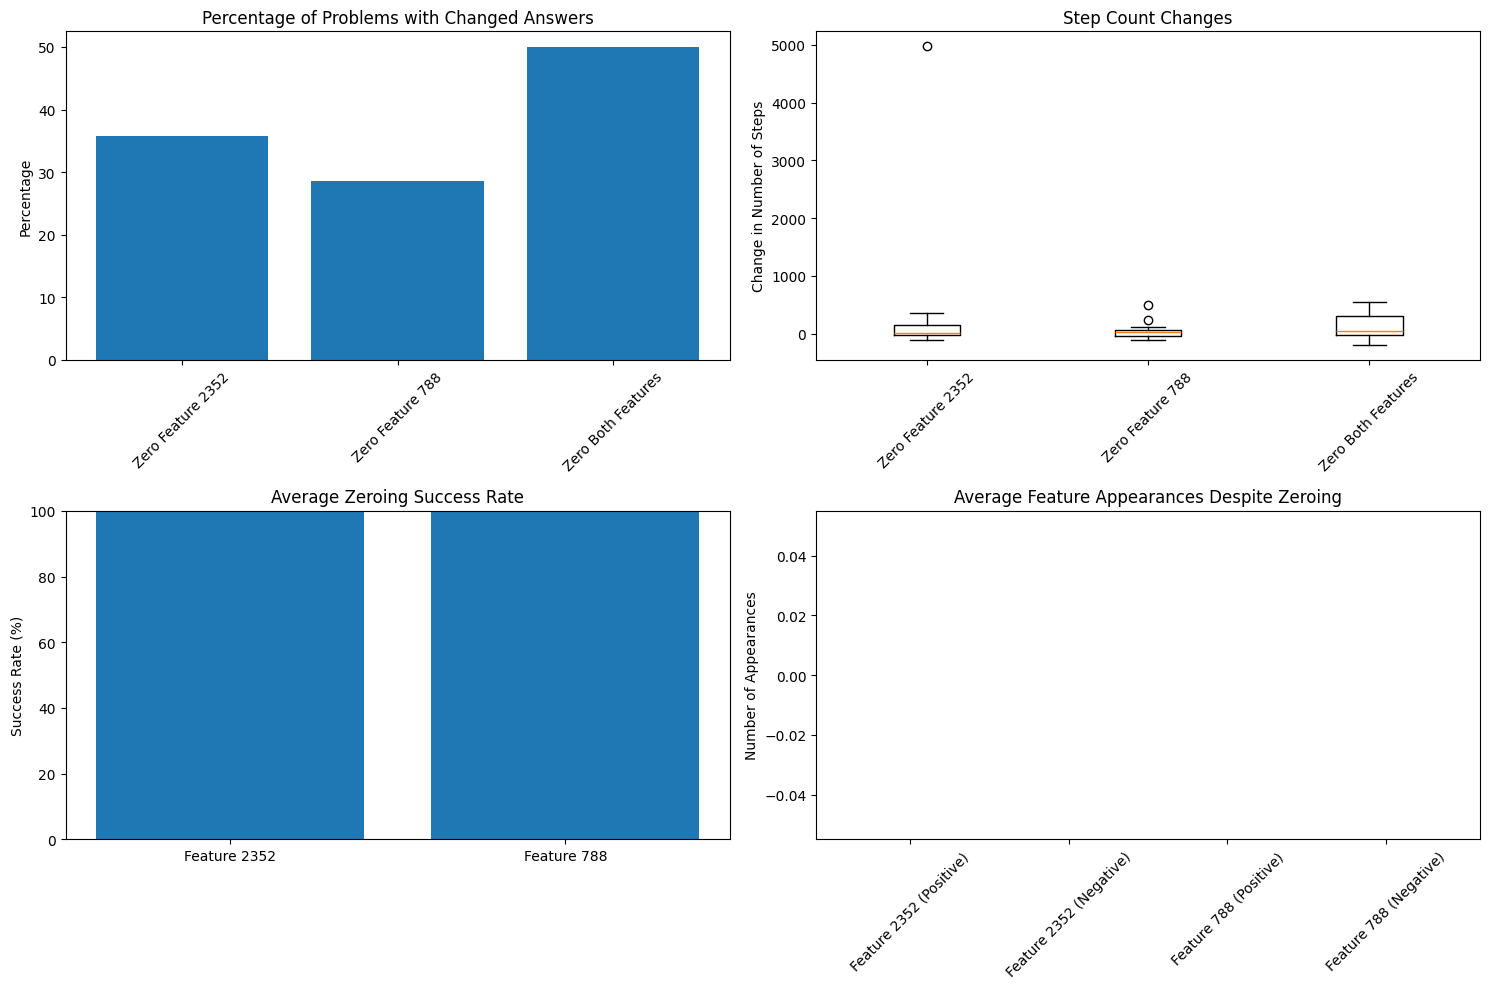

In [ ]:
# Load the correct problems, I did this in the explore data notebook and then moved it over.
# There were in total 14/50 correct solutions
with open('correct_problems.json', 'r') as f:
    correct_problems = json.load(f)

print(f"Loaded {len(correct_problems)} correct problems")

# Run the ablation experiments on a few problems first
ablation_results = run_ablation_experiments(
    model,
    tokenizer,
    correct_problems,
    output_file='ablation_results.json',
    max_problems=14
)

# Analyze the results
analyze_ablation_results('ablation_results.json')

# Visualize the results
visualize_ablation_results('ablation_results.json')